In [1]:
# import statements
import json
import pprint
import matplotlib.pyplot as plt
import math
import statistics
import os
import numpy as np
import copy
from ipynb.fs.full.data_explore import DataExplorer
from ipynb.fs.full.function_prediction import FunctionPrediction
from collections import Counter
import random

/opt/anaconda3/envs/testenv/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


1117


In [25]:
# RawResults class holds all info 
class RawResults():
    def __init__(self, organism_name, n, r, do_alignment=True):
        
        # folder name
        self.organism_name = organism_name
        # length of list of proteins
        self.n = n
        # radius or timestep
        self.r = r
        
        # adjustable variables for raw scoring that we currently do not use
        self.true_positive_reward = 1
        self.false_positive_penalty = -0.25
        self.false_negative_penalty = -0.25
        
        # DataExplorer
        self.data_explorer = DataExplorer(self.organism_name)
        # used to get the actual list of annotations for a protein: self.annotation_dict[self.p[p]]
        self.annotation_dict = self.data_explorer.annotation_list
        # used in get_test_proteins() to gather self.p
        self.names_set = self.data_explorer.filtered_names_set
        self.names_list = self.data_explorer.filtered_names_list
        # used in get_global/local_percentile_ to get list of glosters sorted by size
        self.global_clusters_sorted = self.data_explorer.clusters_sorted
        
        # gathering list of test proteins
        self.p = self.get_test_proteins(n)
        print(self.p)
        # FunctionPrediction
        function_predictor = FunctionPrediction(self.organism_name)
        # raw results 
#         print("starting majority")
        self.majority_approach_results = function_predictor.majority_rule(self.p, r=self.r)
#         print("did majority")
#         print("starting ff")
        self.functional_flow_results = function_predictor.functional_flow(self.p, t=self.r)
#         print("did majority")
        if do_alignment:
            self.alignment_approach_results = function_predictor.alignment_approach(self.p, r=self.r)

    # returns a random size n list of proteins to test
    def get_test_proteins(self, n):
#         p = []
#         for x in range(n):
#             i = random.randint(0, len(self.names_set))
#             while self.names_list[i] in p:
#                 i = random.randint(0, len(self.names_set))
#                 while len(self.annotation_dict[self.names_list[i]]) == 0:
#                     i = random.randint(0, len(self.names_set))
#             p.append(self.names_list[i])
        kz = self.data_explorer.adj_list.keys()
        return random.sample(kz, n)

In [3]:
# compares results from FunctionPrediction to actual
def compare(p, annotation, results):
    true_positive = []
    false_positive = []
    false_negative = []
    for i in range(len(p)):
        protein = p[i]
        true_positive.append([set(), 0])
        false_positive.append([set(), 0])
        false_negative.append([set(), 0])
        actual_clusters = copy.deepcopy(annotation[protein])
        result_clusters = results[protein]
        if len(result_clusters) >= len(actual_clusters):
            for j in range(len(actual_clusters)):
                cluster = result_clusters[j]
                if cluster in actual_clusters:
                    true_positive[i][0].add(cluster)
                    true_positive[i][1] += 1
                    actual_clusters.remove(cluster)
                elif cluster not in actual_clusters:
                    false_positive[i][0].add(cluster)
                    false_positive[i][1] += 1
            for cluster in actual_clusters:
                false_negative[i][0].add(cluster)
                false_negative[i][1] += 1
        elif len(result_clusters) < len(actual_clusters):
            for j in range(len(result_clusters)):
                cluster = actual_clusters[j]
                if cluster in result_clusters:
                    true_positive[i][0].add(cluster)
                    true_positive[i][1] += 1
                    result_clusters.remove(cluster)
                elif cluster not in result_clusters:
                    false_negative[i][0].add(cluster)
                    false_negative[i][1] += 1
            for cluster in result_clusters:
                false_positive[i][0].add(cluster)
                false_positive[i][1] += 1
    return true_positive, false_positive, false_negative

In [4]:
# finds where actual protein clusters fall in the global cluster size distribution
def get_global_percentile_actual(p, true_positive, annotation_dict, global_clusters_sorted):
    percentile = []
    for protein in range(len(p)):
        for c in annotation_dict[p[protein]]:
            i = global_clusters_sorted.index(c)
            percentile.append((i/len(global_clusters_sorted)*100)//1)
    listof100actual = []
    totallen = 0
    for protein in range(len(p)):
        totallen = len(annotation_dict[p[protein]])
    for i in range(100):
        listof100actual.append((percentile.count(i)/totallen*100)//(len(p)))
    return listof100actual

# finds where true positive predictions of protein clusters fall in the global cluster size distribution
def get_global_percentile(p, true_positive, annotation_dict, global_clusters_sorted):
    percentile = []
    for protein in range(len(p)):
        for c in annotation_dict[p[protein]]:
            i = global_clusters_sorted.index(c)
            percentile.append((i/len(global_clusters_sorted)*100)//1)
    listof100actual = []
    totallen = 0
    for protein in range(len(p)):
        totallen = len(annotation_dict[p[protein]])
    for i in range(100):
        listof100actual.append((percentile.count(i)))
    listof100avg = []
    for i in range(100):
        listof100avg.append([])
    percentile = []
    for protein in range(len(p)):
        for tp in true_positive[protein][0]:
            i = global_clusters_sorted.index(tp)
            percentile.append((i/len(global_clusters_sorted)*100)//1)
        listof100result = []
        for i in range(100):
            listof100result.append(percentile.count(i))
        for i in range(100):
            listof100avg[i].append(listof100result[i])
    for i in range(100):
        totalfori = 0
        for j in range(len(listof100avg[i])):
            totalfori += listof100avg[i][j]
        totalfori/=len(listof100avg[i])
        listof100avg[i] = totalfori
    listof100 = []
    for i in range(100):
        if listof100actual[i] == 0:
            listof100.append(0)
        else:
            listof100.append(((listof100avg[i]/listof100actual[i])*100)//1)
    return listof100
        
# finds where actual protein clusters fall in the local cluster size distribution
def get_local_percentile(p, true_positive, annotation_dict, global_clusters_sorted):
    clusters = []
    cluster_len_total = 0
    for protein in range(len(p)):
        cluster_unsorted = annotation_dict[p[protein]]
        cluster_sorted = []
        for c in global_clusters_sorted:
            if c in cluster_unsorted:
                cluster_sorted.append(c)
        clusters.append(cluster_sorted)
        cluster_len_total += len(cluster_sorted)
    percentile = []
    for i in range(100):
        percentile.append(0)
    for i in range(len(p)):
        tpi = true_positive[i]
        ci = clusters[i]
        for tp in tpi[0]:
            percentile[int((ci.index(tp)/len(ci)*100)//1)]+=1
    for i in range(100):
        if percentile[i] != 0:
            percentile[i] == (percentile[i]/(cluster_len_total/100)*100*100)
    return percentile        

In [219]:
class MajorityApproachResults():
    def __init__(self, raw_results):
        self.global_title = 'Global Specificity with Majority Approach'
        self.global_color = '#ff7979'
        self.local_title = 'Local Specificity with Majority Approach'
        self.local_color = '#eb4d4b'
        
        # info gathered from raw_results
        self.p = raw_results.p
        self.annotation_dict = raw_results.annotation_dict
        self.global_clusters_sorted = raw_results.global_clusters_sorted
        self.raw_results = raw_results.majority_approach_results
        #self.tp_reward = raw_results.true_positive_reward
        #self.fp_penalty = raw_results.false_positive_penalty
        #self.fn_penalty = raw_results.false_negative_penalty
        
        # 2D lists of length self.n corresponding to the proteins in self.p: [[{cluster_ids},count]]
        self.true_positive, self.false_positive, self.false_negative = (
            compare(self.p, self.annotation_dict, self.raw_results))
        
        # not currently used
        #self.scores = score(self.p, self.true_positive, self.false_positive, self.false_negative, 
                            #self.tp_reward, self.fp_penalty, self.fn_penalty, self.annotation_dict)
        
        self.global_percentile_actual = get_global_percentile_actual(self.p, self.true_positive, self.annotation_dict,
                                                                     self.global_clusters_sorted)
        self.global_percentile = get_global_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                       self.global_clusters_sorted)
        self.local_percentile = get_local_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                     self.global_clusters_sorted)

In [211]:
class FunctionalFlowResults():
    def __init__(self, raw_results):
        self.global_title = 'Global Specificity with Functional Flow'
        self.global_color = '#7ed6df'
        self.local_title = 'Local Specificity with Functional Flow'
        self.local_color = '#22a6b3'
        
        # info gathered from raw_results
        self.p = raw_results.p
        self.annotation_dict = raw_results.annotation_dict
        self.global_clusters_sorted = raw_results.global_clusters_sorted
        self.raw_results = raw_results.functional_flow_results
        #self.tp_reward = raw_results.true_positive_reward
        #self.fp_penalty = raw_results.false_positive_penalty
        #self.fn_penalty = raw_results.false_negative_penalty
        
        # 2D lists of length self.n corresponding to the proteins in self.p: [[{cluster_ids},count]]
        self.true_positive, self.false_positive, self.false_negative = (
            compare(self.p, self.annotation_dict, self.raw_results))
        
        # not currently used
        #self.scores = score(self.p, self.true_positive, self.false_positive, self.false_negative, 
                            #self.tp_reward, self.fp_penalty, self.fn_penalty, self.annotation_dict)
        
        self.global_percentile_actual = get_global_percentile_actual(self.p, self.true_positive, self.annotation_dict,
                                                                     self.global_clusters_sorted)
        self.global_percentile = get_global_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                       self.global_clusters_sorted)
        self.local_percentile = get_local_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                     self.global_clusters_sorted)

In [212]:
class AlignmentApproachResults():
    def __init__(self, raw_results):
        self.global_title = 'Global Specificity with Alignment Approach'
        self.global_color = '#badc58'
        self.local_title = 'Local Specificity with Alignment Approach'
        self.local_color = '#6ab04c'
        
        # info gathered from raw_results
        self.p = raw_results.p
        self.annotation_dict = raw_results.annotation_dict
        self.global_clusters_sorted = raw_results.global_clusters_sorted
        self.raw_results = raw_results.alignment_approach_results
        #self.tp_reward = raw_results.true_positive_reward
        #self.fp_penalty = raw_results.false_positive_penalty
        #self.fn_penalty = raw_results.false_negative_penalty
        
        # 2D lists of length self.n corresponding to the proteins in self.p: [[{cluster_ids},count]]
        self.true_positive, self.false_positive, self.false_negative = (
            compare(self.p, self.annotation_dict, self.raw_results))
        
        # not currently used
        #self.scores = score(self.p, self.true_positive, self.false_positive, self.false_negative, 
                            #self.tp_reward, self.fp_penalty, self.fn_penalty, self.annotation_dict)
        
        self.global_percentile_actual = get_global_percentile_actual(self.p, self.true_positive, self.annotation_dict,
                                                                     self.global_clusters_sorted)
        self.global_percentile = get_global_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                       self.global_clusters_sorted)
        self.local_percentile = get_local_percentile(self.p, self.true_positive, self.annotation_dict, 
                                                     self.global_clusters_sorted)

In [213]:
# histograms of actual protein clusters in the global cluster size distribution
def get_global_actual_bucket_1(results, r):
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile_actual)):
            percentile[p].append(result.global_percentile_actual[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//= len(percentile[i])
        percentile[i] = totalfori
    left = []
    for i in range(100):
        left.append(i)
    height = percentile
    plt.bar(left, height, width = 1, color ='black')
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Protein Clusters in Percentile")
    plt.title("Global Cluster Size Distribution")
    plt.savefig("results-g/{}-{}.png".format("get_global_actual_bucket_1", str(r)))
    plt.show()
    
def get_global_actual_bucket_2(results, r):
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile_actual)):
            percentile[p].append(result.global_percentile_actual[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//= len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(50):
        fr_this_time.append(0)
    for i in range(50):
        totalfori = 0
        for j in range(2):
            totalfori+=percentile[2*i+j]
        totalfori/=2
        fr_this_time[i] = totalfori
    left = []
    for i in range(50):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','10','','','','','20','','','','','30','','','','', '40','','','','',
                 '50','','','','','60','','','','','70','','','','','80','','','','', '90','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = 'black')
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Protein Clusters in Percentile")
    plt.title("Global Cluster Size Distribution")
    plt.savefig("results-g/{}-{}.png".format("get_global_actual_bucket_2", str(r)))
    plt.show()
    
def get_global_actual_bucket_4(results, r):
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile_actual)):
            percentile[p].append(result.global_percentile_actual[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//= len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(25):
        fr_this_time.append(0)
    for i in range(25):
        totalfori = 0
        for j in range(4):
            totalfori+=percentile[4*i+j]
        totalfori/=4
        fr_this_time[i] = totalfori
    left = []
    for i in range(25):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','20','','','','','40','','','','','60','','','','', '80','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = 'black')
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Protein Clusters in Percentile")
    plt.title("Global Cluster Size Distribution")
    plt.savefig("results-g/{}-{}.png".format("get_global_actual_bucket_4", str(r)))
    plt.show()
    
def get_global_actual_bucket_5(results, r):
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile_actual)):
            percentile[p].append(result.global_percentile_actual[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//= len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(20):
        fr_this_time.append(0)
    for i in range(20):
        totalfori = 0
        for j in range(5):
            totalfori+=percentile[5*i+j]
        totalfori/=5
        fr_this_time[i] = totalfori
    left = []
    for i in range(20):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = 'black')
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Protein Clusters in Percentile")
    plt.title("Global Cluster Size Distribution")
    plt.savefig("results-g/{}-{}.png".format("get_global_actual_bucket_5", str(r)))
    plt.show()

In [326]:
# histograms of true positive predictions of protein clusters in global cluster size distribution
def get_global_bucket_1(results, r, a):
    if a == "maj": color = "#ff7979"
    elif a == "ff": color = "#badc58"
    elif a == "sa": color = "#7ed6df"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile)):
            percentile[p].append(result.global_percentile[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    left = []
    for i in range(100):
        left.append(i)
    height = percentile
    tick_label = ['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95']
    plt.bar(left, height, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].global_title)
    
    bucket = "global-1"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    
    plt.show()
    
def get_global_bucket_2(results, r, a):
    
    if a == "maj": color = "#ff5e57"; edgecolor="#ff3f34"
    elif a == "ff": color = "#0be881"; edgecolor="#05c46b"
    elif a == "sa": color = "#4bcffa"; edgecolor="#0fbcf9"
    
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile)):
            percentile[p].append(result.global_percentile[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(50):
        fr_this_time.append(0)
    for i in range(50):
        totalfori = 0
        for j in range(2):
            totalfori+=percentile[2*i+j]
        totalfori/=2
        fr_this_time[i] = totalfori
    left = []
    for i in range(50):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','10','','','','','20','','','','','30','','','','', '40','','','','',
                 '50','','','','','60','','','','','70','','','','','80','','','','', '90','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color, edgecolor=edgecolor, alpha=0.8)
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].global_title)
    bucket = "global-2"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()

def get_global_bucket_4(results, r, a):
    if a == "maj": color = "#ff7979"
    elif a == "ff": color = "#badc58"
    elif a == "sa": color = "#7ed6df"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile)):
            percentile[p].append(result.global_percentile[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(25):
        fr_this_time.append(0)
    for i in range(25):
        totalfori = 0
        for j in range(4):
            totalfori+=percentile[4*i+j]
        totalfori/=4
        fr_this_time[i] = totalfori
    left = []
    for i in range(25):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','20','','','','','40','','','','','60','','','','', '80','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].global_title)
    bucket = "global-4"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show() 

def get_global_bucket_5(results, r, a):
    if a == "maj": color = "#ff7979"
    elif a == "ff": color = "#badc58"
    elif a == "sa": color = "#7ed6df"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for result in results:
        for p in range(len(result.global_percentile)):
            percentile[p].append(result.global_percentile[p])
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(20):
        fr_this_time.append(0)
    for i in range(20):
        totalfori = 0
        for j in range(5):
            totalfori+=percentile[5*i+j]
        totalfori/=5
        fr_this_time[i] = totalfori
    left = []
    for i in range(20):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Global Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].global_title)
    bucket = "global-5"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()   

In [325]:
# histograms of true positive predictions of protein clusters in local cluster size distribution
def get_local_bucket_1(results, r, a):
    if a == "maj": color = "#eb4d4b"
    elif a == "ff": color = "#6ab04c"
    elif a == "sa": color = "#22a6b3"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for i in range(100):
        for result in results:
            percentile[i].append(result.local_percentile[i]*100)
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    left = []
    for i in range(100):
        left.append(i)
    height = percentile
    plt.bar(left, height, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Local Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].local_title)
    bucket = "local-1"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()

def get_local_bucket_2(results, r, a):
    if a == "maj": color = "#ff5e57"; edgecolor="#ff3f34"
    elif a == "ff": color = "#0be881"; edgecolor="#05c46b"
    elif a == "sa": color = "#4bcffa"; edgecolor="#0fbcf9"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for i in range(100):
        for result in results:
            percentile[i].append(result.local_percentile[i]*100)
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(50):
        fr_this_time.append(0)
    for i in range(50):
        totalfori = 0
        for j in range(2):
            totalfori+=percentile[2*i+j]
        totalfori/=2
        fr_this_time[i] = totalfori
    left = []
    for i in range(50):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','10','','','','','20','','','','','30','','','','', '40','','','','',
                 '50','','','','','60','','','','','70','','','','','80','','','','', '90','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color, edgecolor=edgecolor, alpha=0.8)
    plt.ylim((0,100))
    plt.xlabel("Local Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].local_title)
    bucket = "local-2"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()

def get_local_bucket_4(results, r, a):
    if a == "maj": color = "#eb4d4b"
    elif a == "ff": color = "#6ab04c"
    elif a == "sa": color = "#22a6b3"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for i in range(100):
        for result in results:
            percentile[i].append(result.local_percentile[i]*100)
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(25):
        fr_this_time.append(0)
    for i in range(25):
        totalfori = 0
        for j in range(4):
            totalfori+=percentile[4*i+j]
        totalfori/=4
        fr_this_time[i] = totalfori
    left = []
    for i in range(25):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','','','','','20','','','','','40','','','','','60','','','','', '80','','','','']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Local Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].local_title)
    bucket = "local-4"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()

def get_local_bucket_5(results, r, a):
    if a == "maj": color = "#eb4d4b"
    elif a == "ff": color = "#6ab04c"
    elif a == "sa": color = "#22a6b3"
        
    percentile = []
    for i in range(100):
        percentile.append([])
    for i in range(100):
        for result in results:
            percentile[i].append(result.local_percentile[i]*100)
    for i in range(len(percentile)):
        totalfori = 0
        for j in range(len(percentile[i])):
            totalfori += percentile[i][j]
        totalfori//=len(percentile[i])
        percentile[i] = totalfori
    fr_this_time = []
    for i in range(20):
        fr_this_time.append(0)
    for i in range(20):
        totalfori = 0
        for j in range(5):
            totalfori+=percentile[5*i+j]
        totalfori/=5
        fr_this_time[i] = totalfori
    left = []
    for i in range(20):
        left.append(i)
    height = fr_this_time
    tick_label = ['0','5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95']
    plt.bar(left, height, tick_label = tick_label, width = 1, color = color)
    plt.ylim((0,100))
    plt.xlabel("Local Cluster Size Percentiles")
    plt.ylabel("% Correctly Predicted")
    plt.title(results[0].local_title)
    bucket = "local-5"
    if a == "maj":
        plt.savefig("results-g/maj/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "ff":
        plt.savefig("results-g/ff/{}-{}-{}.png".format(bucket, str(r), a))
    elif a == "sa":
        plt.savefig("results-g/sa/{}-{}-{}.png".format(bucket, str(r), a))
    plt.show()

In [11]:
# majority results held here
majority_list_radius_1 = []
majority_list_radius_2 = []
majority_list_radius_3 = []
majority_list_radius_4 = []
majority_list_radius_5 = []

# flow results held here
flow_list_radius_1 = []
flow_list_radius_2 = []
flow_list_radius_3 = []
flow_list_radius_4 = []
flow_list_radius_5 = []

# align results held here
align_list_radius_1 = []
align_list_radius_2 = []
align_list_radius_3 = []
align_list_radius_4 = []
align_list_radius_5 = []

In [12]:
print("RADIUS 1")
for i in range(50):
    print("ITER {} / {}".format(i+1, 50))
    
    try:
        results = RawResults("ecoli", 5, 1)
        majority_results = MajorityApproachResults(results)
        majority_list_radius_1.append(majority_results)
        flow_results = FunctionalFlowResults(results)
        flow_list_radius_1.append(flow_results)
        align_results = AlignmentApproachResults(results)
        align_list_radius_1.append(align_results)
    except:
        continue

RADIUS 1
ITER 1 / 50
['362663.ECP_3130', '362663.ECP_3234', '362663.ECP_1716', '362663.ECP_0805', '362663.ECP_0314']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 2
WORKING NBORHOOD SIZE: 8
WORKING NBORHOOD SIZE: 9
WORKING NBORHOOD SIZE: 14
WORKING NBORHOOD SIZE: 2
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 34
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 2
WORKING NBORHOOD SIZE: 8
WORKING NBORHOOD SIZE: 9
WORKING NBORHOOD SIZE: 14
WORKING NBORHOOD SIZE: 2
ITER 2 / 50
['362663.ECP_3747', '362663.ECP_1807', '362663.ECP_0885', '362663.ECP_3116', '362663.ECP_0351']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 32
WORKING NBORHOOD SIZE: 22
WORKING NBORHOOD SIZE: 13
WORKING NBORHOOD SIZE: 4
WORKING NBORHOOD SIZE: 1
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 71
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 32
WORKING NBORHOOD SIZE: 22
WORKING NBORHOOD SIZE: 13
WORKING NBORHOOD SIZE: 4
WORKING NBORHOOD SIZE: 1
ITER 3 / 50
['362663.ECP_4273', '362663.ECP_3952', '3

---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 2
WORKING NBORHOOD SIZE: 1
WORKING NBORHOOD SIZE: 7
WORKING NBORHOOD SIZE: 1
WORKING NBORHOOD SIZE: 4
ITER 19 / 50
['362663.ECP_3577', '362663.ECP_2516', '362663.ECP_2525', '362663.ECP_3537', '362663.ECP_4163']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 3
WORKING NBORHOOD SIZE: 29
WORKING NBORHOOD SIZE: 1
WORKING NBORHOOD SIZE: 9
WORKING NBORHOOD SIZE: 13
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 55
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 3
WORKING NBORHOOD SIZE: 29
WORKING NBORHOOD SIZE: 1
WORKING NBORHOOD SIZE: 9
WORKING NBORHOOD SIZE: 13
ITER 20 / 50
['362663.ECP_1224', '362663.ECP_3116', '362663.ECP_2082', '362663.ECP_0423', '362663.ECP_3091']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 3
WORKING NBORHOOD SIZE: 4
WORKING NBORHOOD SIZE: 25
WORKING NBORHOOD SIZE: 1
WORKING NBORHOOD SIZE: 24
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 57
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 3
WORKING 

---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 18
WORKING NBORHOOD SIZE: 18
WORKING NBORHOOD SIZE: 20
WORKING NBORHOOD SIZE: 11
WORKING NBORHOOD SIZE: 20
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 84
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 18
WORKING NBORHOOD SIZE: 18
WORKING NBORHOOD SIZE: 20
WORKING NBORHOOD SIZE: 11
WORKING NBORHOOD SIZE: 20
ITER 37 / 50
['362663.ECP_1804', '362663.ECP_2298', '362663.ECP_1023', '362663.ECP_3768', '362663.ECP_2597']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 19
WORKING NBORHOOD SIZE: 14
WORKING NBORHOOD SIZE: 11
WORKING NBORHOOD SIZE: 3
WORKING NBORHOOD SIZE: 15
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 61
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 19
WORKING NBORHOOD SIZE: 14
WORKING NBORHOOD SIZE: 11
WORKING NBORHOOD SIZE: 3
WORKING NBORHOOD SIZE: 15
ITER 38 / 50
['362663.ECP_3120', '362663.ECP_1157', '362663.ECP_4228', '362663.ECP_3036', '362663.ECP_2593']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE:

In [17]:
print("RADIUS 2")
for i in range(50):
    print("ITER {} / {}".format(i+1, 50))
    
    try:
        results = RawResults("ecoli", 1, 2)
        majority_results = MajorityApproachResults(results)
        majority_list_radius_2.append(majority_results)
        flow_results = FunctionalFlowResults(results)
        flow_list_radius_2.append(flow_results)
        align_results = AlignmentApproachResults(results)
        align_list_radius_2.append(align_results)
    except:
        continue

RADIUS 2
ITER 1 / 50
['362663.ECP_1385']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 15
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 15
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 15
ITER 2 / 50
['362663.ECP_3331']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 25
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 25
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 25
ITER 3 / 50
['362663.ECP_1170']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 23
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 23
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 23
ITER 4 / 50
['362663.ECP_3342']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 45
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 45
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 45
ITER 5 / 50
['362663.ECP_1821']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 5
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 5
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 5
ITER 6 / 50
['362663.ECP_4025']
---- MA

---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 17
ITER 44 / 50
['362663.ECP_1407']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 143
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 143
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 143
ITER 45 / 50
['362663.ECP_2246']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 123
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 123
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 123
ITER 46 / 50
['362663.ECP_1415']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 15
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 15
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 15
ITER 47 / 50
['362663.ECP_4070']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 163
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 163
---- ALIGNMENT APPROACH ----
WORKING NBORHOOD SIZE: 163
ITER 48 / 50
['362663.ECP_2332']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 38
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 38
---- ALIGNMENT APPROACH ----
WO

In [26]:
print("RADIUS 3")
for i in range(20):
    print("ITER {} / {}".format(i+1, 20))
    
    try:
        results = RawResults("ecoli", 1, 3, do_alignment=False)
        majority_results = MajorityApproachResults(results)
        majority_list_radius_3.append(majority_results)
        flow_results = FunctionalFlowResults(results)
        flow_list_radius_3.append(flow_results)
#         align_results = AlignmentApproachResults(results)
#         align_list_radius_3.append(align_results)
    except:
        continue

RADIUS 3
ITER 1 / 20
['362663.ECP_3927']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 612
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 612
ITER 2 / 20
['362663.ECP_0050']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 2
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 2
ITER 3 / 20
['362663.ECP_3717']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 628
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 628
ITER 4 / 20
['362663.ECP_2914']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 1990
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 1990
ITER 5 / 20
['362663.ECP_0845']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 87
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 87
ITER 6 / 20
['362663.ECP_4306']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 251
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 251
ITER 7 / 20
['362663.ECP_0822']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 212
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 212
ITER 8 / 20
['362663.ECP_0842

In [27]:
print("RADIUS 4")
for i in range(20):
    print("ITER {} / {}".format(i+1, 20))
    
    try:
        results = RawResults("ecoli", 1, 4, do_alignment=False)
        majority_results = MajorityApproachResults(results)
        majority_list_radius_4.append(majority_results)
        flow_results = FunctionalFlowResults(results)
        flow_list_radius_4.append(flow_results)
#         align_results = AlignmentApproachResults(results)
#         align_list_radius_4.append(align_results)
    except:
        continue

RADIUS 4
ITER 1 / 20
['362663.ECP_3798']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 59
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 59
ITER 2 / 20
['362663.ECP_1617']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 2203
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 2203
ITER 3 / 20
['362663.ECP_4588']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 52
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 52
ITER 4 / 20
['362663.ECP_2846']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 3
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 3
ITER 5 / 20
['362663.ECP_3718']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 2901
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 2901
ITER 6 / 20
['362663.ECP_0477']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 1820
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 1820
ITER 7 / 20
['362663.ECP_4309']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 1689
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 1689
ITER 8 / 20
['362663.ECP_

In [28]:
print("RADIUS 5")
for i in range(20):
    print("ITER {} / {}".format(i+1, 20))
    
    try:
        results = RawResults("ecoli", 1, 5, do_alignment=False)
        majority_results = MajorityApproachResults(results)
        majority_list_radius_5.append(majority_results)
        flow_results = FunctionalFlowResults(results)
        flow_list_radius_5.append(flow_results)
#         align_results = AlignmentApproachResults(results)
#         align_list_radius_5.append(align_results)
    except:
        continue

RADIUS 5
ITER 1 / 20
['362663.ECP_0746']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 2340
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 2340
ITER 2 / 20
['362663.ECP_0618']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 3452
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 3452
ITER 3 / 20
['362663.ECP_1633']
---- MAJORITY APPROACH ----
WORKING NBORHOOD SIZE: 3218
---- FLOW APPROACH ----
WORKING NBORHOOD SIZE: 3218
ITER 4 / 20
ITER 5 / 20
ITER 6 / 20
ITER 7 / 20
ITER 8 / 20
ITER 9 / 20
ITER 10 / 20
ITER 11 / 20
ITER 12 / 20
ITER 13 / 20
['362663.ECP_1979']
ITER 14 / 20
ITER 15 / 20
ITER 16 / 20
ITER 17 / 20
ITER 18 / 20
['362663.ECP_0978']
ITER 19 / 20
ITER 20 / 20


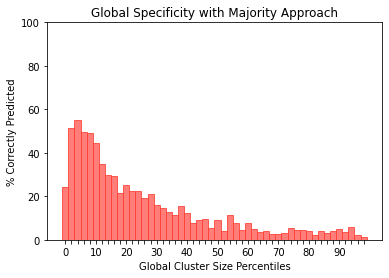

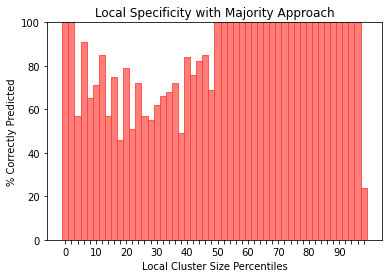

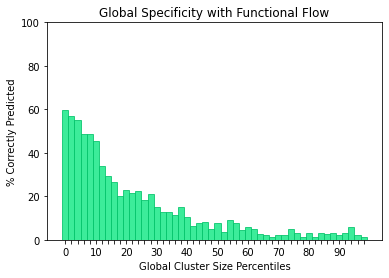

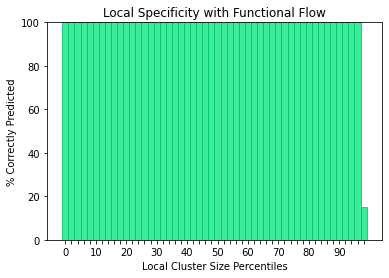

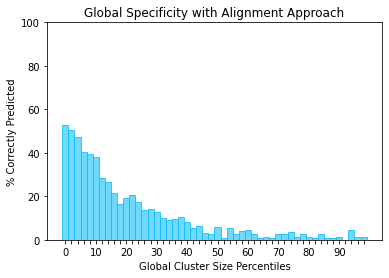

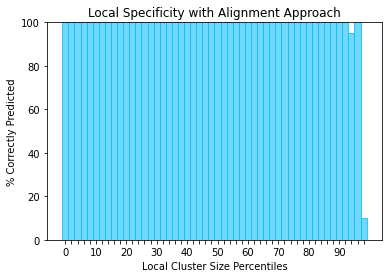

In [327]:
# global stats 
# get_global_actual_bucket_1(majority_list_radius_1, r=1)
# get_global_actual_bucket_2(majority_list_radius_1, r=1)
# get_global_actual_bucket_4(majority_list_radius_1, r=1)
# get_global_actual_bucket_5(majority_list_radius_1, r=1)

# majority radius 2
# get_global_bucket_1(majority_list_radius_1, r=1, a="maj")
get_global_bucket_2(majority_list_radius_1, r=1, a="maj")
# get_global_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_global_bucket_5(majority_list_radius_1, r=1, a="maj")

# get_local_bucket_1(majority_list_radius_1, r=1, a="maj")
get_local_bucket_2(majority_list_radius_1, r=1, a="maj")
# get_local_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_local_bucket_5(majority_list_radius_1, r=1, a="maj")

# flow radius 2 
# get_global_bucket_1(flow_list_radius_1, r=1, a="ff")
get_global_bucket_2(flow_list_radius_1, r=1, a="ff")
# get_global_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_global_bucket_5(flow_list_radius_1, r=1, a="ff")

# get_local_bucket_1(flow_list_radius_1, r=1, a="ff")
get_local_bucket_2(flow_list_radius_1, r=1, a="ff")
# get_local_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_local_bucket_5(flow_list_radius_1, r=1, a="ff")

# align radius 2
# get_global_bucket_1(align_list_radius_1, r=1, a="sa")
get_global_bucket_2(align_list_radius_1, r=1, a="sa")
# get_global_bucket_4(align_list_radius_1, r=1, a="sa")
# get_global_bucket_5(align_list_radius_1, r=1, a="sa")

# get_local_bucket_1(align_list_radius_1, r=1, a="sa")
get_local_bucket_2(align_list_radius_1, r=1, a="sa")
# get_local_bucket_4(align_list_radius_1, r=1, a="sa")
# get_local_bucket_5(align_list_radius_1, r=1, a="sa")

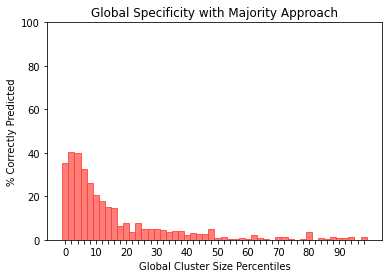

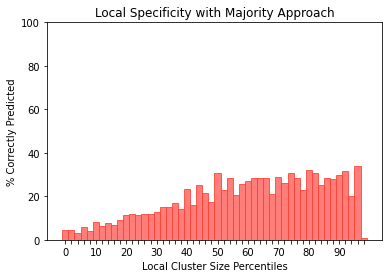

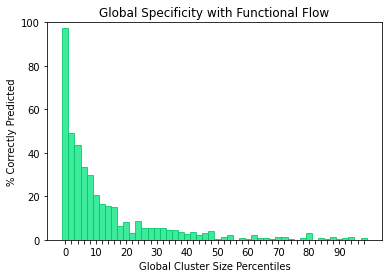

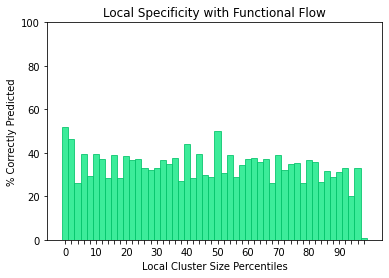

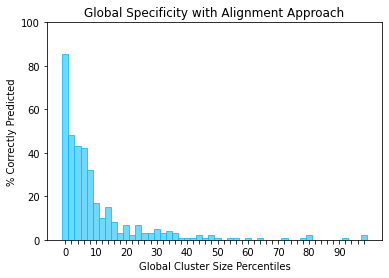

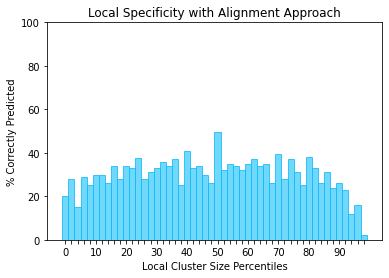

In [328]:
# global stats 
# get_global_actual_bucket_1(majority_list_radius_1, r=1)
# get_global_actual_bucket_2(majority_list_radius_1, r=1)
# get_global_actual_bucket_4(majority_list_radius_1, r=1)
# get_global_actual_bucket_5(majority_list_radius_1, r=1)

# majority radius 2
# get_global_bucket_1(majority_list_radius_1, r=1, a="maj")
get_global_bucket_2(majority_list_radius_2, r=2, a="maj")
# get_global_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_global_bucket_5(majority_list_radius_1, r=1, a="maj")

# get_local_bucket_1(majority_list_radius_1, r=1, a="maj")
get_local_bucket_2(majority_list_radius_2, r=2, a="maj")
# get_local_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_local_bucket_5(majority_list_radius_1, r=1, a="maj")

# flow radius 2 
# get_global_bucket_1(flow_list_radius_1, r=1, a="ff")
get_global_bucket_2(flow_list_radius_2, r=2, a="ff")
# get_global_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_global_bucket_5(flow_list_radius_1, r=1, a="ff")

# get_local_bucket_1(flow_list_radius_1, r=1, a="ff")
get_local_bucket_2(flow_list_radius_2, r=2, a="ff")
# get_local_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_local_bucket_5(flow_list_radius_1, r=1, a="ff")

# align radius 2
# get_global_bucket_1(align_list_radius_1, r=1, a="sa")
get_global_bucket_2(align_list_radius_2, r=2, a="sa")
# get_global_bucket_4(align_list_radius_1, r=1, a="sa")
# get_global_bucket_5(align_list_radius_1, r=1, a="sa")

# get_local_bucket_1(align_list_radius_1, r=1, a="sa")
get_local_bucket_2(align_list_radius_2, r=2, a="sa")
# get_local_bucket_4(align_list_radius_1, r=1, a="sa")
# get_local_bucket_5(align_list_radius_1, r=1, a="sa")

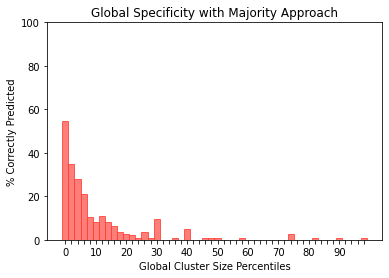

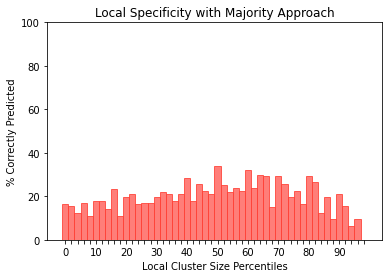

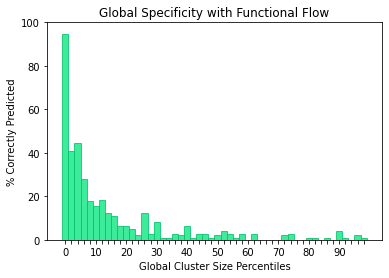

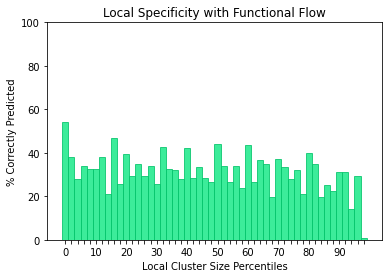

ZeroDivisionError: integer division or modulo by zero

In [329]:
# global stats 
# get_global_actual_bucket_1(majority_list_radius_1, r=1)
# get_global_actual_bucket_2(majority_list_radius_1, r=1)
# get_global_actual_bucket_4(majority_list_radius_1, r=1)
# get_global_actual_bucket_5(majority_list_radius_1, r=1)

# majority radius 2
# get_global_bucket_1(majority_list_radius_1, r=1, a="maj")
get_global_bucket_2(majority_list_radius_3, r=3, a="maj")
# get_global_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_global_bucket_5(majority_list_radius_1, r=1, a="maj")

# get_local_bucket_1(majority_list_radius_1, r=1, a="maj")
get_local_bucket_2(majority_list_radius_3, r=3, a="maj")
# get_local_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_local_bucket_5(majority_list_radius_1, r=1, a="maj")

# flow radius 2 
# get_global_bucket_1(flow_list_radius_1, r=1, a="ff")
get_global_bucket_2(flow_list_radius_3, r=3, a="ff")
# get_global_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_global_bucket_5(flow_list_radius_1, r=1, a="ff")

# get_local_bucket_1(flow_list_radius_1, r=1, a="ff")
get_local_bucket_2(flow_list_radius_3, r=3, a="ff")
# get_local_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_local_bucket_5(flow_list_radius_1, r=1, a="ff")

# align radius 2
# get_global_bucket_1(align_list_radius_1, r=1, a="sa")
get_global_bucket_2(align_list_radius_3, r=3, a="sa")
# get_global_bucket_4(align_list_radius_1, r=1, a="sa")
# get_global_bucket_5(align_list_radius_1, r=1, a="sa")

# get_local_bucket_1(align_list_radius_1, r=1, a="sa")
get_local_bucket_2(align_list_radius_3, r=3, a="sa")
# get_local_bucket_4(align_list_radius_1, r=1, a="sa")
# get_local_bucket_5(align_list_radius_1, r=1, a="sa")

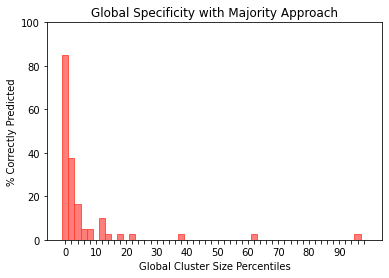

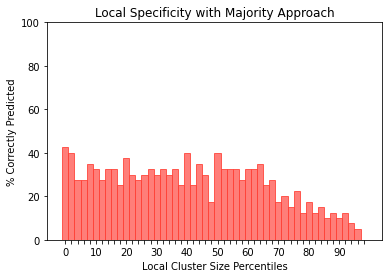

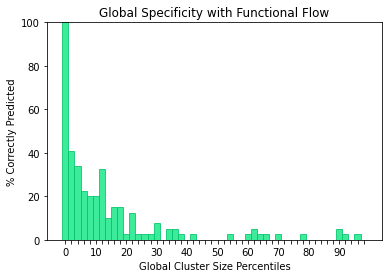

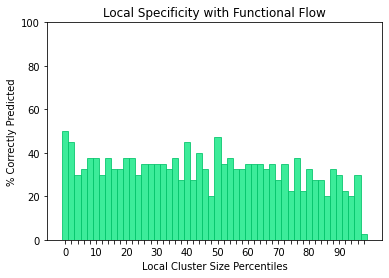

ZeroDivisionError: integer division or modulo by zero

In [330]:
# global stats 
# get_global_actual_bucket_1(majority_list_radius_1, r=1)
# get_global_actual_bucket_2(majority_list_radius_1, r=1)
# get_global_actual_bucket_4(majority_list_radius_1, r=1)
# get_global_actual_bucket_5(majority_list_radius_1, r=1)

# majority radius 2
# get_global_bucket_1(majority_list_radius_1, r=1, a="maj")
get_global_bucket_2(majority_list_radius_4, r=4, a="maj")
# get_global_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_global_bucket_5(majority_list_radius_1, r=1, a="maj")

# get_local_bucket_1(majority_list_radius_1, r=1, a="maj")
get_local_bucket_2(majority_list_radius_4, r=4, a="maj")
# get_local_bucket_4(majority_list_radius_1, r=1, a="maj")
# get_local_bucket_5(majority_list_radius_1, r=1, a="maj")

# flow radius 2 
# get_global_bucket_1(flow_list_radius_1, r=1, a="ff")
get_global_bucket_2(flow_list_radius_4, r=4, a="ff")
# get_global_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_global_bucket_5(flow_list_radius_1, r=1, a="ff")

# get_local_bucket_1(flow_list_radius_1, r=1, a="ff")
get_local_bucket_2(flow_list_radius_4, r=4, a="ff")
# get_local_bucket_4(flow_list_radius_1, r=1, a="ff")
# get_local_bucket_5(flow_list_radius_1, r=1, a="ff")

# align radius 2
# get_global_bucket_1(align_list_radius_1, r=1, a="sa")
get_global_bucket_2(align_list_radius_4, r=4, a="sa")
# get_global_bucket_4(align_list_radius_1, r=1, a="sa")
# get_global_bucket_5(align_list_radius_1, r=1, a="sa")

# get_local_bucket_1(align_list_radius_1, r=1, a="sa")
get_local_bucket_2(align_list_radius_4, r=4, a="sa")
# get_local_bucket_4(align_list_radius_1, r=1, a="sa")
# get_local_bucket_5(align_list_radius_1, r=1, a="sa")

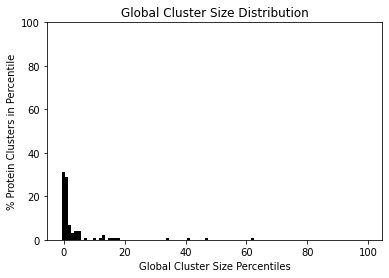

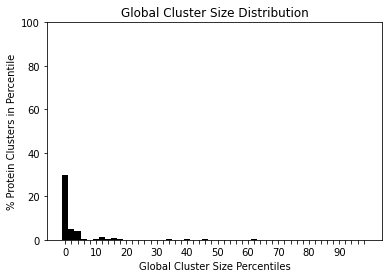

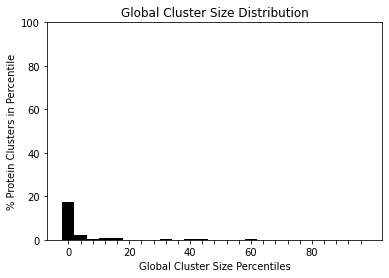

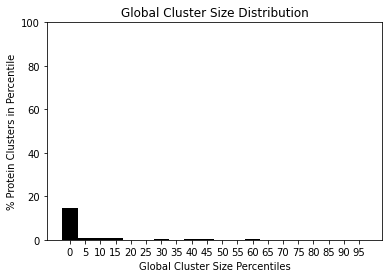

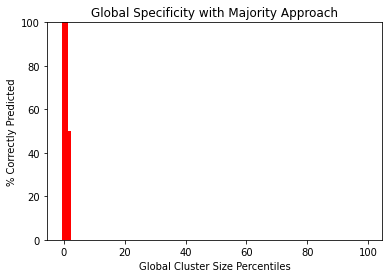

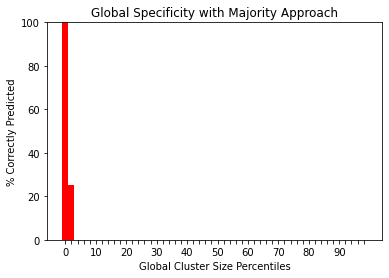

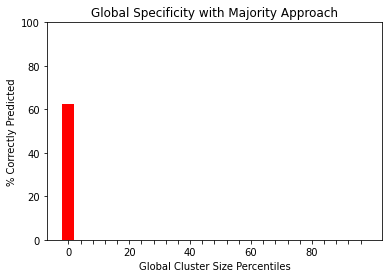

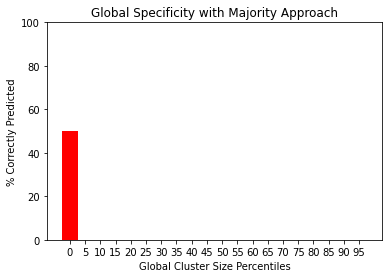

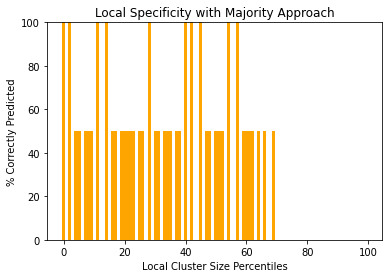

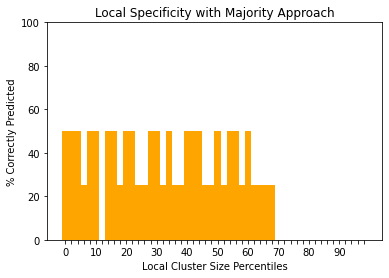

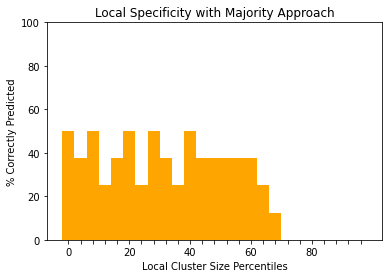

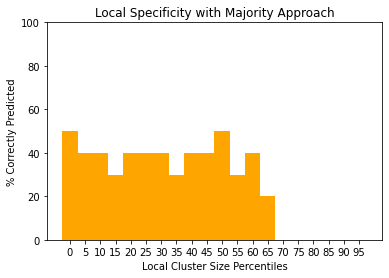

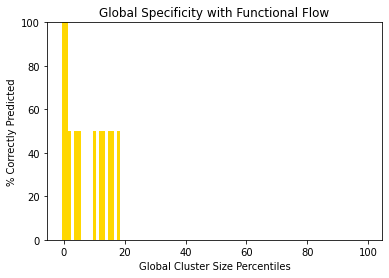

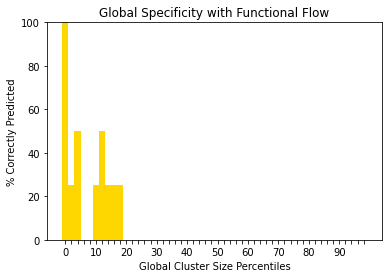

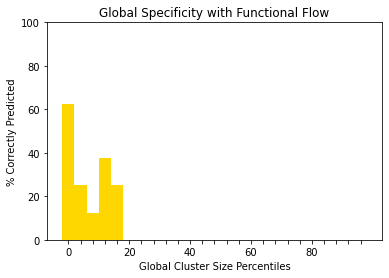

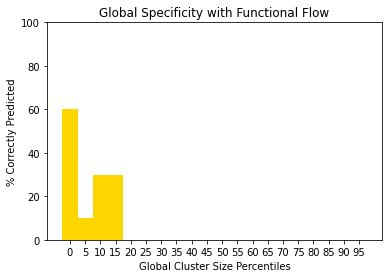

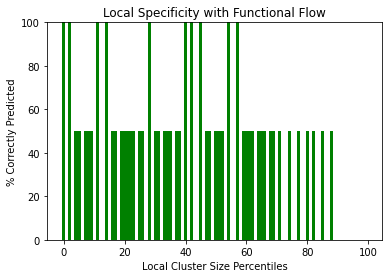

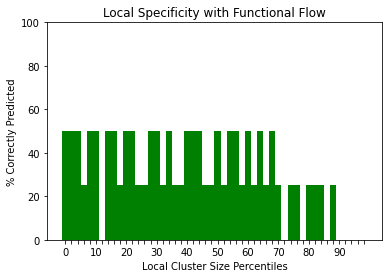

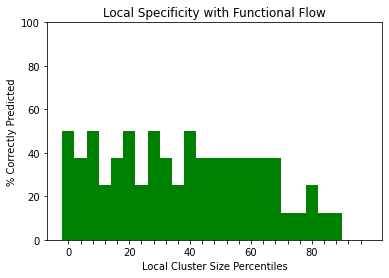

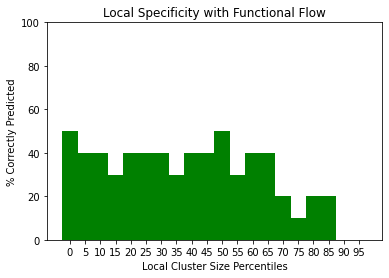

ZeroDivisionError: integer division or modulo by zero

In [62]:
# global stats 
get_global_actual_bucket_1(majority_list_radius_5, r=5)
get_global_actual_bucket_2(majority_list_radius_5, r=5)
get_global_actual_bucket_4(majority_list_radius_5, r=5)
get_global_actual_bucket_5(majority_list_radius_5, r=5)

# majority radius 2
get_global_bucket_1(majority_list_radius_5, r=5, a="maj")
get_global_bucket_2(majority_list_radius_5, r=5, a="maj")
get_global_bucket_4(majority_list_radius_5, r=5, a="maj")
get_global_bucket_5(majority_list_radius_5, r=5, a="maj")

get_local_bucket_1(majority_list_radius_5, r=5, a="maj")
get_local_bucket_2(majority_list_radius_5, r=5, a="maj")
get_local_bucket_4(majority_list_radius_5, r=5, a="maj")
get_local_bucket_5(majority_list_radius_5, r=5, a="maj")

# flow radius 2 
get_global_bucket_1(flow_list_radius_5, r=5, a="ff")
get_global_bucket_2(flow_list_radius_5, r=5, a="ff")
get_global_bucket_4(flow_list_radius_5, r=5, a="ff")
get_global_bucket_5(flow_list_radius_5, r=5, a="ff")

get_local_bucket_1(flow_list_radius_5, r=5, a="ff")
get_local_bucket_2(flow_list_radius_5, r=5, a="ff")
get_local_bucket_4(flow_list_radius_5, r=5, a="ff")
get_local_bucket_5(flow_list_radius_5, r=5, a="ff")

# align radius 2
get_global_bucket_1(align_list_radius_5, r=5, a="sa")
get_global_bucket_2(align_list_radius_5, r=5, a="sa")
get_global_bucket_4(align_list_radius_5, r=5, a="sa")
get_global_bucket_5(align_list_radius_5, r=5, a="sa")

get_local_bucket_1(align_list_radius_5, r=5, a="sa")
get_local_bucket_2(align_list_radius_5, r=5, a="sa")
get_local_bucket_4(align_list_radius_5, r=5, a="sa")
get_local_bucket_5(align_list_radius_5, r=5, a="sa")

In [91]:
def jaccard(pred_labels, true_labels, weights=None):
    # compute weighted/non-weighted jaccard distance between true and predicted labels
    # smaller weights indicate higher importance
    
    pred_labels = set(pred_labels)
    true_labels = set(true_labels)
    
    intersection = pred_labels.intersection(true_labels)
    union = pred_labels.union(true_labels)
    
    if weights:
        intersection_size = sum([
            (1 / weights[label]) for label in intersection
        ])
        
        union_size = sum([
            (1 / weights[label]) for label in union
        ])
    else:
        intersection_size = len(intersection)
        union_size = len(union)
    
    return intersection_size / union_size

def precision(pred_labels, true_labels, weights=None):
    # compute weighted/non-weighted precision between true and predicted labels
    # smaller weights indicate higher importance
    
    pred_labels = set(pred_labels)
    true_labels = set(true_labels)
    
    intersection = pred_labels.intersection(true_labels)
    
    if weights:
        intersection_size = sum([
            (1 / weights[label]) for label in intersection
        ])
        
        pred_size = sum([
            (1 / weights[label]) for label in pred_labels
        ])
    else:
        intersection_size = len(intersection)
        pred_size = len(pred_labels)
    
    return intersection_size / pred_size

def recall(pred_labels, true_labels, weights=None):
    # compute weighted/non-weighted recall between true and predicted labels
    # smaller weights indicate higher importance
    
    pred_labels = set(pred_labels)
    true_labels = set(true_labels)
    
    intersection = pred_labels.intersection(true_labels)
    false_negatives = true_labels.difference(pred_labels)
    
    if weights:
        intersection_size = sum([
            (1 / weights[label]) for label in intersection
        ])
        
        false_negative_size = sum([
            (1 / weights[label]) for label in false_negatives
        ])
    else:
        intersection_size = len(intersection)
        false_negative_size = len(false_negatives)
    
    return intersection_size / (intersection_size + false_negative_size)

def f1_score(pred_labels, true_labels, weights=None):
    precision_score = precision(pred_labels, true_labels, weights)
    recall_score = recall(pred_labels, true_labels, weights)
    
    return (2 * precision_score * recall_score) / (precision_score + recall_score)

In [64]:
data_explorer = DataExplorer("ecoli")
weights = data_explorer.cluster_sizes

In [113]:
majority_scores = {
    1: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    2: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    3: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    4: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    } 
}


maj_res = [majority_list_radius_1, majority_list_radius_2, majority_list_radius_3, majority_list_radius_4]

for n in range(len(maj_res)):
    cnt = 0
    for trial in maj_res[n]:
        for i in range(len(trial.p)):
            cnt += 1

            tp, _ = trial.true_positive[i]
            fp, _ = trial.false_positive[i]

            pred_labels = list(tp) + list(fp)
            true_labels = data_explorer.annotation_list[trial.p[i]]
            try:
                majority_scores[n+1]["jaccard"]["weighted"] += jaccard(pred_labels,true_labels,weights)
                majority_scores[n+1]["jaccard"]["nonweighted"] += jaccard(pred_labels,true_labels)
            except: pass
            
            try:
                majority_scores[n+1]["precision"]["weighted"] += precision(pred_labels,true_labels,weights)
                majority_scores[n+1]["precision"]["nonweighted"] += precision(pred_labels,true_labels)
            except: pass
            
            try:
                majority_scores[n+1]["recall"]["weighted"] += recall(pred_labels,true_labels,weights)
                majority_scores[n+1]["recall"]["nonweighted"] += recall(pred_labels,true_labels)
            except: pass
            
            try:
                majority_scores[n+1]["f1"]["weighted"] += f1_score(pred_labels,true_labels,weights)
                majority_scores[n+1]["f1"]["nonweighted"] += f1_score(pred_labels,true_labels)
            except: cnt -= 1
    for method in majority_scores[n+1]:
        for w in majority_scores[n+1][method]:
            majority_scores[n+1][method][w] /= cnt
        
print("--- MAJORITY SCORES (ACCURACY) ---")
pprint.pprint(majority_scores)

--- MAJORITY SCORES (ACCURACY) ---
{1: {'f1': {'nonweighted': 0.6344978091304612, 'weighted': 0.5076751283647868},
     'jaccard': {'nonweighted': 0.5371672409644366,
                 'weighted': 0.4169256802162931},
     'precision': {'nonweighted': 0.6344978091304612,
                   'weighted': 0.41759534028314454},
     'recall': {'nonweighted': 0.6344978091304612,
                'weighted': 0.9518809034697929}},
 2: {'f1': {'nonweighted': 0.5319737289552062, 'weighted': 0.30577462160239915},
     'jaccard': {'nonweighted': 0.4118292994756624,
                 'weighted': 0.19992285879541613},
     'precision': {'nonweighted': 0.5319737289552062,
                   'weighted': 0.2310100423852752},
     'recall': {'nonweighted': 0.5319737289552062,
                'weighted': 0.7558343100193493}},
 3: {'f1': {'nonweighted': 0.5621592162625773, 'weighted': 0.22039213783579795},
     'jaccard': {'nonweighted': 0.4378510459402271,
                 'weighted': 0.15203827321499394},


In [116]:
ff_scores = {
    1: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    2: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    3: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    4: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    } 
}


ff_res = [flow_list_radius_1, flow_list_radius_2, flow_list_radius_3, flow_list_radius_4]

for n in range(len(ff_res)):
    cnt = 0
    for trial in ff_res[n]:
        for i in range(len(trial.p)):
            cnt += 1

            tp, _ = trial.true_positive[i]
            fp, _ = trial.false_positive[i]

            pred_labels = list(tp) + list(fp)
            true_labels = data_explorer.annotation_list[trial.p[i]]
            try:
                ff_scores[n+1]["jaccard"]["weighted"] += jaccard(pred_labels,true_labels,weights)
                ff_scores[n+1]["jaccard"]["nonweighted"] += jaccard(pred_labels,true_labels)
            except: pass
            
            try:
                ff_scores[n+1]["precision"]["weighted"] += precision(pred_labels,true_labels,weights)
                ff_scores[n+1]["precision"]["nonweighted"] += precision(pred_labels,true_labels)
            except: pass
            
            try:
                ff_scores[n+1]["recall"]["weighted"] += recall(pred_labels,true_labels,weights)
                ff_scores[n+1]["recall"]["nonweighted"] += recall(pred_labels,true_labels)
            except: pass
            
            try:
                ff_scores[n+1]["f1"]["weighted"] += f1_score(pred_labels,true_labels,weights)
                ff_scores[n+1]["f1"]["nonweighted"] += f1_score(pred_labels,true_labels)
            except: cnt -= 1
    for method in ff_scores[n+1]:
        for w in ff_scores[n+1][method]:
            ff_scores[n+1][method][w] /= cnt
        
print("--- FLOW SCORES (ACCURACY) ---")
pprint.pprint(ff_scores)

--- FLOW SCORES (ACCURACY) ---
{1: {'f1': {'nonweighted': 0.9730917251625726, 'weighted': 0.8505799465700936},
     'jaccard': {'nonweighted': 0.9584335031283657,
                 'weighted': 0.8198545505061814},
     'precision': {'nonweighted': 0.9733334656944016,
                   'weighted': 0.8858020990398314},
     'recall': {'nonweighted': 0.9728809770066189,
                'weighted': 0.8471003408594655}},
 2: {'f1': {'nonweighted': 0.9530191771717829, 'weighted': 0.7655464103325873},
     'jaccard': {'nonweighted': 0.926890829727221,
                 'weighted': 0.7323881621183782},
     'precision': {'nonweighted': 0.9530191771717829,
                   'weighted': 0.8223194690336526},
     'recall': {'nonweighted': 0.9530191771717829,
                'weighted': 0.7724218874517506}},
 3: {'f1': {'nonweighted': 0.9556110834167636, 'weighted': 0.7681014550404673},
     'jaccard': {'nonweighted': 0.925984221571721,
                 'weighted': 0.7273699549081143},
     'preci

In [118]:
sa_scores = {
    1: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    2: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    3: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    },
    4: {
        "jaccard": {"weighted": 0, "nonweighted": 0},
        "precision": {"weighted": 0, "nonweighted": 0},
        "recall": {"weighted": 0, "nonweighted": 0},
        "f1": {"weighted": 0, "nonweighted": 0}
    } 
}


sa_res = [align_list_radius_1, align_list_radius_2]

for n in range(len(sa_res)):
    cnt = 0
    for trial in sa_res[n]:
        for i in range(len(trial.p)):
            cnt += 1

            tp, _ = trial.true_positive[i]
            fp, _ = trial.false_positive[i]

            pred_labels = list(tp) + list(fp)
            true_labels = data_explorer.annotation_list[trial.p[i]]
            try:
                sa_scores[n+1]["jaccard"]["weighted"] += jaccard(pred_labels,true_labels,weights)
                sa_scores[n+1]["jaccard"]["nonweighted"] += jaccard(pred_labels,true_labels)
            except: print('eee')
            
            try:
                sa_scores[n+1]["precision"]["weighted"] += precision(pred_labels,true_labels,weights)
                sa_scores[n+1]["precision"]["nonweighted"] += precision(pred_labels,true_labels)
            except: print('eee')
            
            try:
                sa_scores[n+1]["recall"]["weighted"] += recall(pred_labels,true_labels,weights)
                sa_scores[n+1]["recall"]["nonweighted"] += recall(pred_labels,true_labels)
            except: print('eee')
            
            try:
                sa_scores[n+1]["f1"]["weighted"] += f1_score(pred_labels,true_labels,weights)
                sa_scores[n+1]["f1"]["nonweighted"] += f1_score(pred_labels,true_labels)
            except: cnt -= 1
    for method in sa_scores[n+1]:
        for w in sa_scores[n+1][method]:
            sa_scores[n+1][method][w] /= cnt
        
print("--- ALIGNMENT SCORES (ACCURACY) ---")
pprint.pprint(sa_scores)

--- ALIGNMENT SCORES (ACCURACY) ---
{1: {'f1': {'nonweighted': 0.8982362191324702, 'weighted': 0.6325369368166054},
     'jaccard': {'nonweighted': 0.8558336737405661,
                 'weighted': 0.5820962173583011},
     'precision': {'nonweighted': 0.9047159232670205,
                   'weighted': 0.6459534276390086},
     'recall': {'nonweighted': 0.8925658702790871,
                'weighted': 0.669965604774998}},
 2: {'f1': {'nonweighted': 0.8580654000482375, 'weighted': 0.4417907477121367},
     'jaccard': {'nonweighted': 0.78978643367622,
                 'weighted': 0.3687797606930392},
     'precision': {'nonweighted': 0.8622282913647318,
                   'weighted': 0.4425254466591803},
     'recall': {'nonweighted': 0.8542792587439569,
                'weighted': 0.48450874301492197}},
 3: {'f1': {'nonweighted': 0, 'weighted': 0},
     'jaccard': {'nonweighted': 0, 'weighted': 0},
     'precision': {'nonweighted': 0, 'weighted': 0},
     'recall': {'nonweighted': 0, 'wei

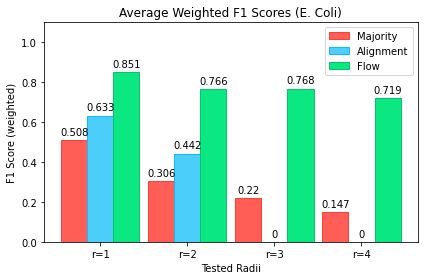

In [332]:
fig, ax = plt.subplots()

w = "weighted"
method = "f1"

width=0.3
x = np.arange(len([1, 2, 3, 4]))
y1 = [round(majority_scores[1][method][w], 3),
      round(majority_scores[2][method][w], 3),
      round(majority_scores[3][method][w], 3),
      round(majority_scores[4][method][w], 3)]

y2 = [round(ff_scores[1][method][w], 3),
      round(ff_scores[2][method][w], 3),
      round(ff_scores[3][method][w], 3),
      round(ff_scores[4][method][w], 3)]

y3 = [round(sa_scores[1][method][w], 3),
      round(sa_scores[2][method][w], 3), 0, 0]

b1 = ax.bar(x - width, y1, width, label="Majority", color="#ff5e57",edgecolor="#ff3f34")
b2 = ax.bar(x, y3, width, label="Alignment", color="#4bcffa",edgecolor="#0fbcf9")
b3 = ax.bar(x + width, y2, width, label="Flow", color="#0be881",edgecolor="#05c46b")

ax.bar_label(b1, padding=3)
ax.bar_label(b2, padding=3)
ax.bar_label(b3, padding=3)
ax.set_xticks(x, ["r=1", "r=2", "r=3", "r=4"])
ax.set_ylim([0, 1.1])

ax.set_title("Average Weighted F1 Scores (E. Coli)")
ax.set_ylabel("F1 Score ({})".format(w))
ax.set_xlabel("Tested Radii")

fig.tight_layout()
plt.legend(loc='upper right')

plt.savefig("results-g/{}-scores-{}.png".format(method, w))
plt.show()

In [ ]:
# not used currently
def score(p, true_pos, false_pos, false_neg, tp_reward, fp_penalty, fn_penalty, annotations):
    all_scores = []
    for i in range(len(p)):
        score_sum = 0
        score_sum += true_pos[i][1]*tp_reward
        score_sum += false_pos[i][1]*fp_penalty
        score_sum += false_neg[i][1]*fn_penalty
        score_percent = score_sum/len(annotations[p[i]])
        all_scores.append(score_percent)
    return all_scores

In [33]:
# not currently used
def get_accuracy(results):
    temp_dict = dict()
    temp_set = set()
    x1 = []
    y1 = []
    for result in results:
        temp_set.add(result.r)
    for result in results:
        temp = 0
        for p in range(len(result.p)):
            temp += ((result.true_positive_majority[p][1])/len(result.annotation_dict[result.p[p]]))
        temp_dict[result.r] = (temp/len(result.p))
    for x in temp_dict:
        x1.append(x)
        y1.append(temp_dict[x])
    plt.plot(x1, y1, label = "Majority Approach")

    temp_dict = dict()
    temp_set = set()
    x2 = []
    y2 = []
    for result in results:
        temp_set.add(result.r)
    for result in results:
        temp = 0
        for p in range(len(result.p)):
            temp += ((result.true_positive_flow[p][1])/len(result.annotation_dict[result.p[p]]))
        temp_dict[result.r] = (temp/len(result.p))
    for x in temp_dict:
        x2.append(x)
        y2.append(temp_dict[x])
    print(x2, y2)
    plt.plot(x2, y2, label = "Functional Flow")

    temp_dict = dict()
    temp_set = set()
    x3 = []
    y3 = []
    for result in results:
        temp_set.add(result.r)
    for result in results:
        temp = 0
        for p in range(len(result.p)):
            temp += ((result.true_positive_align[p][1])/len(result.annotation_dict[result.p[p]]))
        temp_dict[result.r] = (temp/len(result.p))
    for x in temp_dict:
        x3.append(x)
        y2.append(temp_dict[x])
    plt.plot(x3, y3, label = "Alignment Approach")

    plt.xlabel("radius r or timestep t")
    plt.ylabel('accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()
    plt.show()

Text(0.5, 1.0, '')

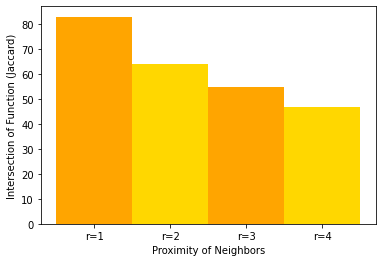

In [337]:
# used for presentation
# plots proximity v intersection of function
left = [1,2,3,4]
height = [83, 64, 55, 47]
tick_label = ['r=1', 'r=2', 'r=3', 'r=4']
plt.bar(left, height, tick_label = tick_label,
        width = 1, color = ['orange', 'gold'])
plt.xlabel('Proximity of Neighbors')
plt.ylabel('Intersection of Function (Jaccard)')
plt.title('')
#plt.show()

12


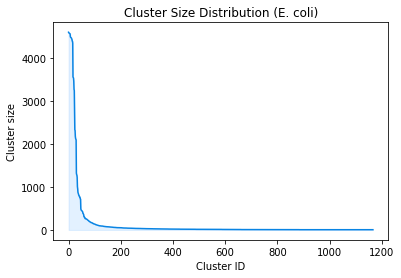

In [312]:
def cluster_plot():
    clusters = data_explorer.cluster_sizes
    sizes = sorted(list(clusters.values()))[::-1]
    
    print(statistics.median(sizes))
    
    #   n, x, _ = plt.hist(sizes)  
    plt.plot(sizes, color = "#0984e3")
    plt.fill_between(range(len(sizes)), 0, sizes, color="#74b9ff", alpha=0.2)
    
    plt.title("Cluster Size Distribution (E. coli)")
    plt.xlabel("Cluster ID")
    plt.ylabel("Cluster size")
    plt.savefig("cluster-dist.png")
#     plt.plot(sizes,sizes)
cluster_plot()

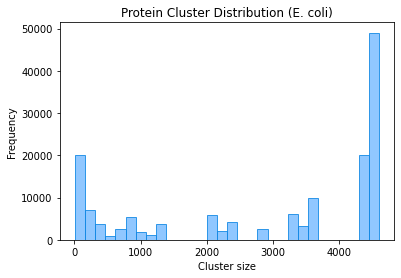

In [336]:
def cluster_protein():
    kz = data_explorer.adj_list.keys()
    random_proteins = kz
    
    sizes = []
    for protein in random_proteins:
        for c in data_explorer.annotation_list[protein]:
            sizes.append(data_explorer.cluster_sizes[c])
    
#     plt.plot(sizes, color = "#2980b9")
    plt.title("Protein Cluster Distribution (E. coli)")
    plt.xlabel("Cluster size")
    plt.ylabel("Frequency")
    
    plt.hist(sizes, bins=30, color="#74b9ff", edgecolor='#0984e3', alpha=0.8)
    plt.savefig("protein-dist.png")

cluster_protein()